# NEST SIMULATION 
##### 1. IMPORTING DATA:
###### 1.1 FROM SNUDDA GENERATED NEURON FILES:
    a) Neuron Matrix: to keep the info of neuron types 
    b) Synaptic Matrix: Where each row has the info of [preID, posID] of one synapse \
    for now every synapse will have the same properties, no matter the types of neurons\
    (later we can add more info on this matrix that will help set the type of synapses used for each)\
    c*) (optional/not really relevant but already available) Positions: matrix with coordinates for each neuron position\
    d) Info about the input given to the neurons
###### 1.2 MODEL PARAMETERS FROM .CSVS
##### 2) CREATING THE NEST NETWORK \
    a) Create the neurons (the correct # of neurons, in their posiiton*)\
    b) Connect the neurons (for loop with Synaptic Matrix as info)\
    c) Connect the measuring devices to the neurons in order to observe spiking and voltage \
    d) Create the spike generators to feed the input 
##### 3) RUN THE SIM
##### 4) SIM RESULTS
    

### 0. LIBRARIES

In [1]:
import nest
import matplotlib.pyplot as plt
import csv
from random import randrange

from getData import *
from plot import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### 1. IMPORTING DATA

In [2]:
positions_list = getNeuronPositions('net_100')

synaptic_matrix = getSynapses('net_100')

input_matrix = getInput('net_100', 100)

neuron_IDs = getNeuronMatrix('/home/ubuntu/BasalGanglia/NEURON-data/net_100')

In [5]:
file = open("/home/ubuntu/BasalGanglia/NEST-params/dspn_params.csv")
csvreader = csv.reader(file)
dspn_params = []
for row in csvreader:
    res = [float(value) for value in row[0].split(';')]    
    dspn_params.append(res)
file.close()

file = open("/home/ubuntu/BasalGanglia/NEST-params/ispn_params.csv")
csvreader = csv.reader(file)
ispn_params = []
for row in csvreader:
    res = [float(value) for value in row[0].split(';')]
    ispn_params.append(res)
file.close()

file = open("/home/ubuntu/BasalGanglia/NEST-params/fs_params.csv")
csvreader = csv.reader(file)
fs_params = []
for row in csvreader:
    res = [float(value) for value in row[0].split(';')]
    fs_params.append(res)
file.close()

chin_params = [[11.65139394,-50,194.5705]]

lts_params = [[1.259667491,-46.06675265,85.9879]]

### 2. CREATING THE NEST NETWORK

Here we create a position list, with the coordinates of each neuron of the network.
(This first step is not necessary, since the spatial distribution of the network does not influence the NEST simulation.)

In [6]:
pos = nest.spatial.free(positions_list) # using NEURON positions

Now we create all the neurons at once, with same characteristics. They are all conductance based integrate and fire model, with the default parameters of nest.\
(to accomodate differente models, this will have to be upgraded, so that the creation parameters can change according to type. once this is done changes in the connection protocol will be needed, bc they wont all be in the same population) [idea: if possible to apply changes with "set" command instead of in the moment of creation, to make it easier]

In [7]:
s_nodes = nest.Create("iaf_cond_alpha", 99, positions=pos) 

In [8]:
#creating the parameter arrays for g_L, e_L and c_M
gL = []
eL = []
Cm = []

for i in range (0, len(neuron_IDs)):
    
    #retrieves neuron type
    neuron_type = neuron_IDs[i][1]
        
    if (neuron_type == 'dspn'):
        
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(dspn_params))
        
        gL.append(dspn_params[index][0])
        eL.append(dspn_params[index][1])
        Cm.append(dspn_params[index][2])
                
    elif (neuron_type == 'ispn'):
        
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(ispn_params))
        
        gL.append(ispn_params[index][0])
        eL.append(ispn_params[index][1])
        Cm.append(ispn_params[index][2])
                
        
    elif (neuron_type == 'fs'):
        
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(fs_params))
        
        gL.append(fs_params[index][0])
        eL.append(fs_params[index][1])
        Cm.append(fs_params[index][2])
            
    elif (neuron_type == 'lts'):
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(lts_params))
        
        gL.append(lts_params[index][0])
        eL.append(lts_params[index][1])
        Cm.append(lts_params[index][2])

    elif (neuron_type == 'chin'):
        #randomly selects one of the sets of parameters for dspn
        index = randrange(len(chin_params))
        
        gL.append(chin_params[index][0])
        eL.append(chin_params[index][1])
        Cm.append(chin_params[index][2])        


In [9]:
s_nodes.set({'g_L': gL, 'E_L': eL, 'C_m': Cm})

With the info of the synaptic matrix, we create the pre-synaptic as post-synaptic neuron ID lists, and transform them into numpy arrays

In [10]:
pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes[synaptic_matrix[i][0]])
    pos_list.append(s_nodes[synaptic_matrix[i][1]])
    
pre_array = np.transpose(np.array(pre_list)).flatten()
pos_array = np.transpose(np.array(pos_list)).flatten()

With the arrays ready, we can connect the synapses all in one command.
(again here, if we wish to have different parameters and arguments for each synapse, a more complex solution is necessary.)

In [11]:
syn_matrix = old_getWeightedSynapses(pre_array,pos_array)

[[ 1  5  3]
 [ 1  6  1]
 [ 1  9  4]
 ...
 [99 93  3]
 [99 95  2]
 [99 97  2]]


In [12]:
syn_wgt = [] 
conductances = []
for i in range(0,len(syn_matrix)):
    
    neuron_type = neuron_IDs[syn_matrix[i][0]-1][1]
        
    if (neuron_type == 'dspn' or neuron_type == 'ispn' ):
        #"conductance": [2.4e-10, 1e-10]
        cond = np.random.normal(2.4e-10,  1e-10, 1)
        
        if(cond<2.4e-11): #capping at 10% of mean
            cond = 2.4e-11
    elif (neuron_type == 'lts'):
        # conductance mean = 3e-09, std deviation =  0
        cond = 3e-09
        
    elif (neuron_type == 'fs'):
        #"conductance": [1.1e-09, 1.5e-09],
        cond = np.random.normal(1.1e-09, 1.5e-09, 1)
        
        if(cond<1.1e-10): #capping at 10% of mean
            cond = 1.1e-10
    
    conductances.append(cond)   

In [13]:
weights = []
for i in range(0, len(conductances)):
    weights.append(-1*conductances[i]*syn_matrix[i][2])
weights = np.row_stack(weights).flatten()

In [14]:
sources = syn_matrix[:,0]
targets = syn_matrix[:,1]

In [15]:
nest.Connect(sources,targets,conn_spec= "one_to_one", syn_spec= {"weight": weights})

Now onto the creation of the Spike Generators.

In [16]:
inputs = nest.Create("spike_generator", 99)

In [17]:
for g, generator in enumerate(inputs):
    
    #spk_wgt = np.full(len(input_matrix[g]), 2.0)
    #nest.SetStatus(generator, {"spike_times": input_matrix[g], "spike_weights": spk_wgt})
    nest.SetStatus(generator, {"spike_times": input_matrix[g]})

In [18]:
spikerecorder = nest.Create("spike_recorder")

In [19]:
input_syn_wgt = np.full(len(inputs), 10.0)
nest.Connect(inputs,s_nodes, conn_spec= "one_to_one", syn_spec={"weight": input_syn_wgt})

In [20]:
nest.Connect(s_nodes,spikerecorder, conn_spec= "all_to_all")

In [21]:
multimeter = nest.Create("multimeter")
multimeter.set(record_from=["V_m"])
nest.Connect(multimeter,s_nodes, "all_to_all")

In [22]:
mult1 = nest.Create("multimeter", 5)
mult1.set(record_from=["V_m"])
chosen_nodes = [1,11,21,31,41]
nest.Connect(mult1,chosen_nodes, "one_to_one")

### RUNNING THE SIMULATION
Here we are using a total run itme of 2000 ms (and the default step of simulation of 0.1 ms)

In [23]:
nest.Simulate(2000.0)


Nov 15 12:17:35 NodeManager::prepare_nodes [Info]: 
    Preparing 205 nodes for simulation.

Nov 15 12:17:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 205
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Nov 15 12:17:37 SimulationManager::run [Info]: 
    Simulation finished.


### ANALYSING THE RESULTS

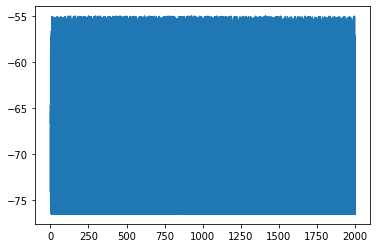

In [24]:
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
ids = dmm["events"]["senders"]

plt.figure(1)
plt.plot(ts, Vms)
plt.show()

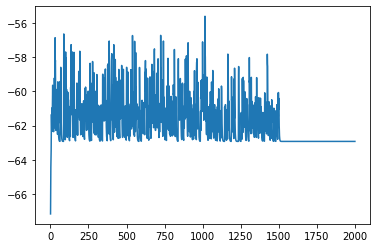

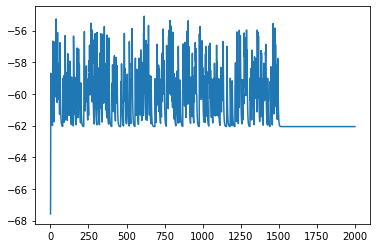

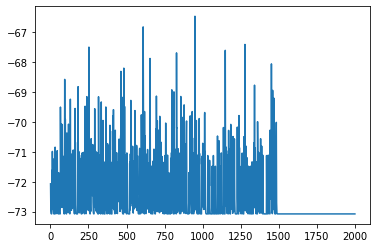

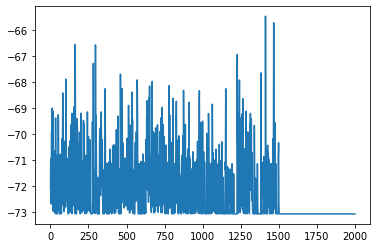

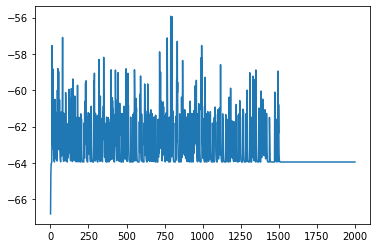

In [25]:
for i in range(0,5):
    dmm1 = mult1[i].get()
    Vms1 = dmm1["events"]["V_m"]
    ts1 = dmm1["events"]["times"]
    ids1 = dmm1["events"]["senders"]

    plt.figure(1)
    plt.plot(ts1, Vms1)
    plt.show()

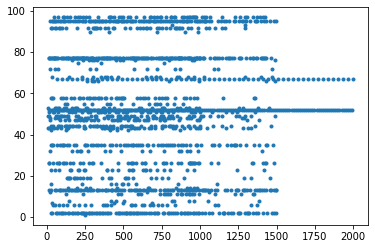

In [26]:
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.figure(2)
plt.plot(ts, evs, ".")
plt.show()

In [27]:
print("Senders of events(IDs) :", evs)
print("Spike times: ", ts)

Senders of events(IDs) : [43 49 53 ... 52 52 67]
Spike times:  [   9.     9.9   10.1 ... 1977.8 1991.4 1996.2]


In [26]:
d = {}
for key, val in evs, ts:
    d.setdefault(key, []).append(val)

print(d)

ValueError: too many values to unpack (expected 2)

In [ ]:
print(spk_dict.get(92))

### OTHERS

In [ ]:
def plotRaster(folder_path, size):
    ''' Given a path to a folder inside NEURON-data, generates the raster plot for the corresponding simulation
        (folder_path is "NEURON-data/net_X" )
    '''    
    spikes_dict = getSpikes(folder_path, size)
    
    n_ids = np.array(list(spikes_dict.keys()), dtype=int)
    n_ids.sort() #organize the neurons by id

    neuron_matrix = getNeuronMatrix(folder_path)
    dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_matrix)
    
    orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


    fig_handle = plt.figure()
    ax = fig_handle.add_subplot(111)
    ax.set_xlabel('$t$ (ms)')

    plotSpikes(spikes_dict, fs_ID, orderedIDs, fs_color, 'fs', ax)
    plotSpikes(spikes_dict, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
    plotSpikes(spikes_dict, lts_ID, orderedIDs, lts_color, 'lts', ax)
    plotSpikes(spikes_dict, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
    plotSpikes(spikes_dict, chin_ID, orderedIDs, chin_color, 'chin', ax)


    plt.legend()
    plt.show()
